In [ ]:
import re
import pandas as pd
import bs4 # beautifulSoup : python web scraping library for pulling the data from web pages, documents, HTML, and XML files
import requests
import matplotlib.pyplot as plt
# Tqdm(Taqaddum) used to create a smart progress bar for the loops. You just need to wrap tqdm on any iterable - tqdm(iterable).
from tqdm import tqdm

import spacy #open-source python library for NLP written in Cython language
from spacy import displacy #A modern syntactic dependency visualizer

from spacy.matcher import Matcher
from spacy.tokens import Span

# Python library for studying graphs and networks
import networkx as nx

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

## Import sentences using pandas

In [ ]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences.head(3)

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.


In [ ]:
# en_core_web_sm is a small English pipeline trained on written web text (blogs, news, comments),
# that includes vocabulary, syntax and entities.
nlp = spacy.load('en_core_web_sm')

doc = nlp("christian is then paralyzed by an elder.")#nlp("The first computer was designed by Alan Turing")

for tok in doc:
  print(tok.text, "...", tok.dep_)

christian ... nsubjpass
is ... auxpass
then ... advmod
paralyzed ... ROOT
by ... agent
an ... det
elder ... pobj
. ... punct


## The nouns and the proper nouns would be our entities. When one entity spans several words then defining POS tags is not enough, we need to also parse the dependency tree for that entity

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""
  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence
  prefix = ""
  modifier = "" # word, phrase, or clause that modifies or gives information about—another word in the same sentence. e.g. vegan burger

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      ## Found the first entity
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        # reset variables for next entity
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      # Found the second entity
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        # reset variables for next entity
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

## Create entity pairs(Subject-Object) for all examples in csv

In [ ]:
entity_pairs = []

for sent in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(sent))

100%|██████████| 4318/4318 [00:46<00:00, 92.75it/s] 


In [ ]:
entity_pairs[0:3]

[['connie', 'own'],
 ['later  scream', 'distance'],
 ['christian', 'then  elder']]

## Extract the relations : ROOT is the pos which defines relation

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  # Matcher lets you find words and phrases using rules describing their token attributes
  # An individual token — i.e. a word, punctuation symbol, whitespace, etc.
  matcher = Matcher(nlp.vocab)

  #define the pattern
  # OP: + means Require the pattern to match 1 or more times.
  # OP: ? means Make the pattern optional, by allowing it to match 0 or 1 times.
  # OP: * means Allow the pattern to match 0 or more times.
  pattern = [[{'DEP':'ROOT'}, {'DEP':'prep','OP':"?"},{'DEP':'agent','OP':"?"},  {'POS':'ADJ','OP':"?"}]]

  matcher.add("matching_1", pattern)

  matches = matcher(doc)
  k = len(matches) - 1

# Create a Span object from the slice doc[start : end].
  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

## Get the relations for all sentences in csv

In [ ]:
relations = [get_relation(row) for row in tqdm(candidate_sentences['sentence'],position=0)]
pd.Series(relations).value_counts()[:15]

100%|██████████| 4318/4318 [00:43<00:00, 100.06it/s]


is             364
was            308
released on     90
are             74
include         73
were            68
released        41
's              39
composed by     34
became          31
have            31
has             30
become          28
released in     27
included        23
dtype: int64

## Create a dataframe of source , target and edges for graph creation

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

## Draw a Knowledge Graph for all sentences

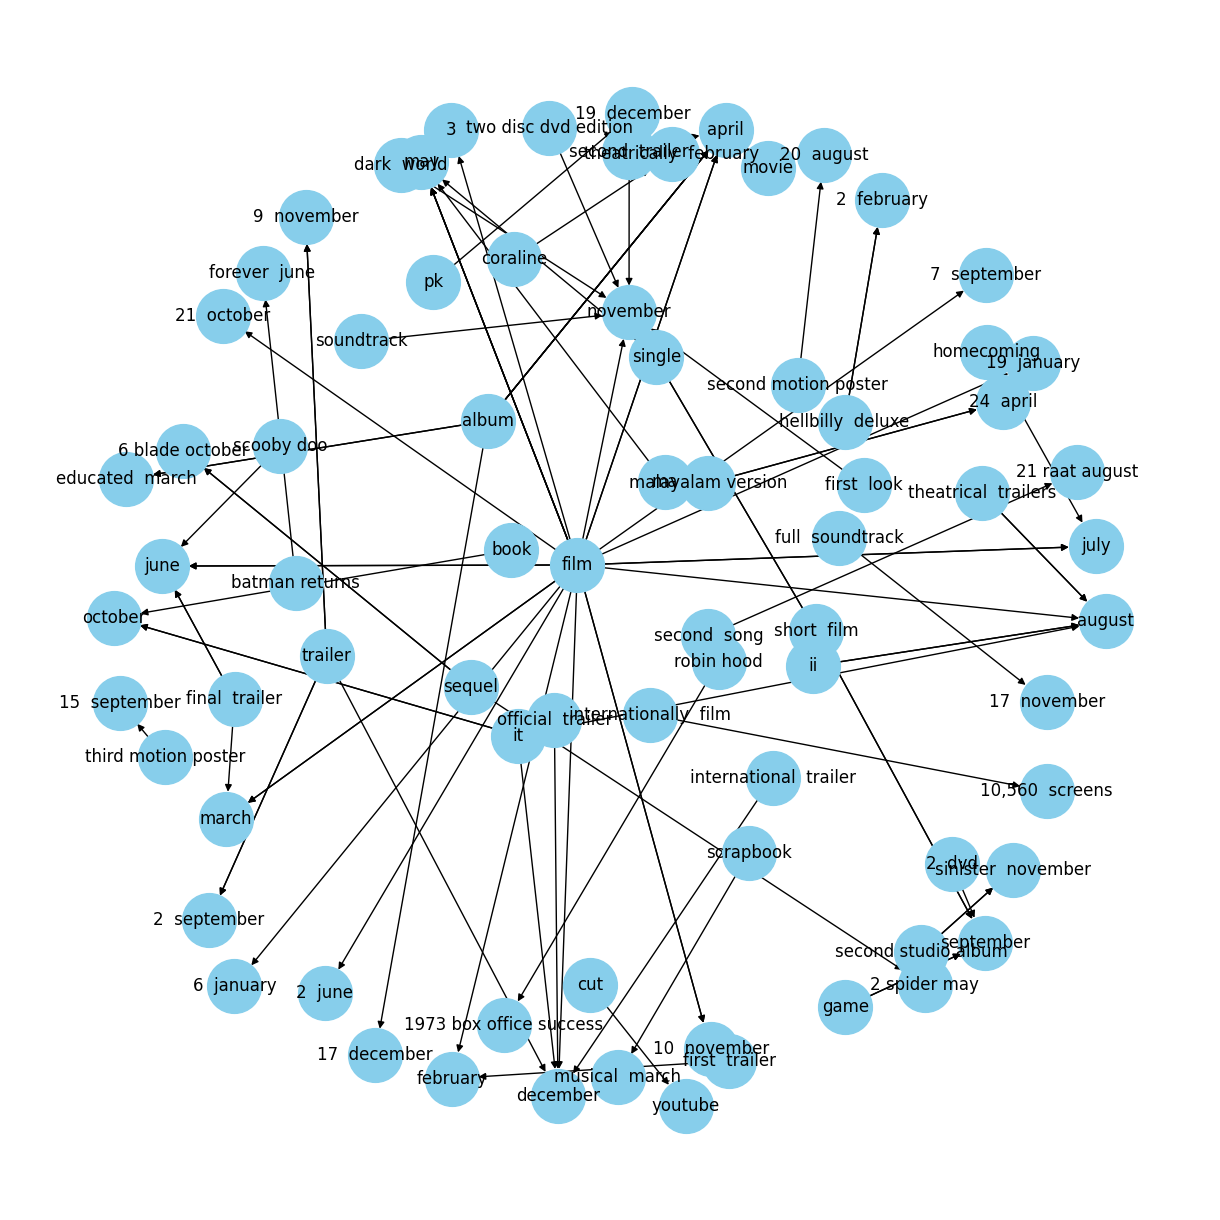

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released on"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
kg_df[kg_df['edge']=="released on"]

,source,target,edge
45,single,may,released on
386,final trailer,march,released on
581,film,july,released on
582,film,may,released on
583,film,may,released on
...,...,...,...
4116,it,august,released on
4119,film,november,released on
4137,robin hood,1973 box office success,released on
4141,film,march,released on
